In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import jax
import numpy as np

In [193]:
import glob
import pandas as pd

path = 'data_completa11'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [192]:
def pre_process(df):
    feature_keys = ['pm25','pm10','no2','temp','velv','hrel']
    df.columns = df.columns.str.strip()
    df['date_time']=pd.to_datetime(df[['anho', 'mes', 'dia', 'hora']].rename(columns={'anho': 'year', 'mes': 'month', 'dia': 'day', 'hora': 'hour'}))
    df.drop(columns=['anho', 'mes', 'dia','hora'],inplace=True)
    df.drop(columns=['numero_semana', 'numero_dia', 'tipo_dia','estacion_anho'],inplace=True)
    df.set_index('date_time',inplace=True)
    for key in feature_keys:
        if key in df.columns:
            df[key] =df[key].astype(str).str.replace(',', '.').astype(float)
            #df[key].fillna(df[key].mean(), inplace=True)  
    df.resample('1h').sum()      
    return df

In [194]:
df_preprocessed = [pre_process(df) for df in df_list]

In [196]:
df_preprocessed[0].head()

,Estacion,E,N,pm25,pm10,no2,temp,velv,hrel
date_time,,,,,,,,,
2010-01-01 00:00:00,Pudahuel,337311,6298809,10.0,25.0,13.0,16.9250,2.14056,69.0000
2010-01-01 01:00:00,Pudahuel,337311,6298809,12.0,26.0,14.0,16.0750,2.13333,73.1665
2010-01-01 02:00:00,Pudahuel,337311,6298809,12.0,26.0,16.0,15.1833,1.49166,78.1665
2010-01-01 03:00:00,Pudahuel,337311,6298809,10.0,26.0,15.0,14.6833,1.40000,81.6665
2010-01-01 04:00:00,Pudahuel,337311,6298809,10.0,25.0,13.0,14.5000,1.05000,83.5000


In [197]:
df_group=pd.concat(df_preprocessed)

In [100]:
def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

def create_batch_multistep(df,lag,future,feature=None):
    if feature is None:
        data=df
    else:
        data=df[feature]
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    df_future=pd.concat([data[lag-1:].shift(-i) for i in range(1,future+1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=df_future.values
    return X,y

In [200]:
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=1
past=24
dataset_names=list()
for item_id, gdf in df_group.groupby('Estacion'):
    print(f"Processing station: {item_id}")
    gdf = gdf.drop(columns=['Estacion'])
    gdf = gdf.sort_index()
    feature_keys = ['pm25','pm10','no2','temp','velv','hrel']
    # Split data into training and validation sets
    train_data, val_data = train_test_split(gdf, 0.8, feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in feature_keys:
    # Create batches for training and validation
        X_train, y_train = create_batch_multistep(train_data, lag=past, future=future,feature=feature)
        X_val, y_val = create_batch_multistep(val_data, lag=past, future=future,feature=feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_val)
        if feature=='pm25':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_val)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
X_train_datasets=np.stack(X_train_datasets,axis=0)
X_train_datasets=X_train_datasets.swapaxes(-1,-2)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
X_test_datasets=X_test_datasets.swapaxes(-1,-2)
y_test_datasets=np.stack(y_test_datasets,axis=0)

Processing station: Cerrillos
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: CerroNavia
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: ElBosque
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Independencia
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: LaFlorida
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: LasCondes
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: ParqueOhiggins
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Pudahuel
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: PuenteAlto
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Quilicura
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Talagante
Train shape: (42042, 24), Validation shape: (10493, 24)


In [201]:
X_test_datasets.shape,y_test_datasets.shape

((11, 10493, 6, 24), (11, 10493, 1))

In [202]:
import jax
import jax.numpy as jnp

def get_dataloader(X,y,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[:,batch_indices,:,:], y[:,batch_indices]

In [203]:
import optax
from flax import linen as nn
from functools import partial
import distrax

class LSTM(nn.Module):

    @nn.remat
    @nn.compact
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]

def log_likelihood(params, x, y):
    preds = jax.vmap(model.apply, (0, 0))(params, jnp.array(x,dtype=jnp.float32))
    return -1.0*jnp.mean(distrax.Normal(preds,1).log_prob(jnp.array(y,dtype=jnp.float32)).sum(axis=-1))

grad_log_post=jax.jit(jax.grad(log_likelihood))

@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree.map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree.map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree.map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree.map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree.map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [204]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [205]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
n_features=len(feature_keys)
inputs = jax.random.randint(key,(batch_size,n_features,past),0, 10,).astype(jnp.float32)
key_tasks=jax.random.split(key_model,n_groups)
params_tasks = jax.vmap(model.init, (0, None))(key_tasks, inputs)

In [206]:
X_train_datasets[:,0:256,:,:].shape

(11, 256, 6, 24)

In [207]:
inputs.shape

(256, 6, 24)

In [208]:
y_train_datasets[:,0:32,:].shape

(11, 32, 1)

In [209]:
jax.tree.map(lambda p: p.shape, params_tasks)

{'params': {'Dense_0': {'bias': (11, 1), 'kernel': (11, 32, 1)},
  'LSTMCell_0': {'hf': {'bias': (11, 32), 'kernel': (11, 32, 32)},
   'hg': {'bias': (11, 32), 'kernel': (11, 32, 32)},
   'hi': {'bias': (11, 32), 'kernel': (11, 32, 32)},
   'ho': {'bias': (11, 32), 'kernel': (11, 32, 32)},
   'if': {'kernel': (11, 24, 32)},
   'ig': {'kernel': (11, 24, 32)},
   'ii': {'kernel': (11, 24, 32)},
   'io': {'kernel': (11, 24, 32)}}}}

In [210]:
preds = jax.vmap(model.apply, (0, 0))(params_tasks, jnp.array(X_train_datasets[:,0:32,:,:]))

In [211]:
preds.shape

(11, 32, 1)

In [212]:
log_likelihood(params_tasks, X_train_datasets[:,0:32,:,:], y_train_datasets[:,0:32,:])

/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


Array(1.1577942, dtype=float32)

In [213]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 50,
                             dt, params_tasks,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 0, loss 1.17


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 5, loss 1.07


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 10, loss 0.98


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 15, loss 1.02


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 20, loss 1.01


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 25, loss 0.99


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 30, loss 0.98


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 35, loss 0.98


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 40, loss 0.98


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

iteration 45, loss 0.98


/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sergio/virtualenvs/jax/lib/pytho

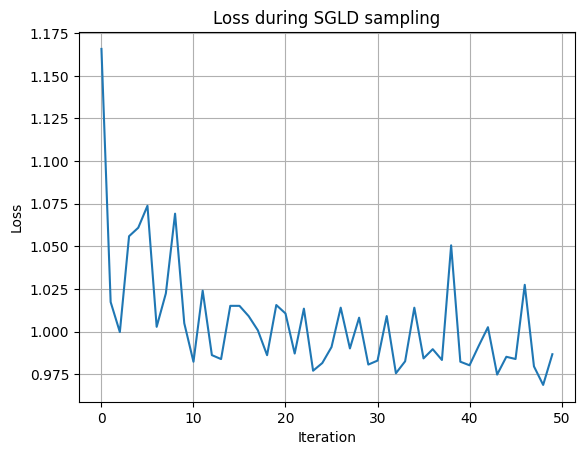

In [214]:
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss during SGLD sampling')
plt.grid()
plt.show()

In [215]:
preds = jax.vmap(model.apply, (0, 0))(params_tasks, jnp.array(X_test_datasets[:,0:32,:,:]))

In [218]:
y_test_datasets[:,0:32,:].shape,preds.shape

((11, 32, 1), (11, 32, 1))

Text(0.5, 0, 'Time step')

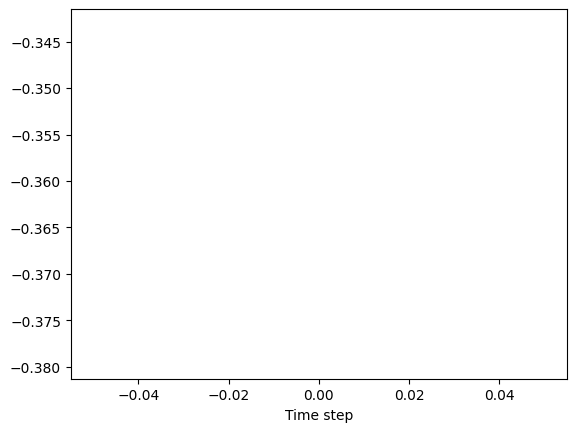

In [219]:
plt.plot(y_test_datasets[0,0,:], label='True')
#plt.plot(preds[0,0,:], label='Predicted')
plt.xlabel('Time step')

In [220]:
import pickle

with open('sgld.samples', 'wb') as samples_file:
    pickle.dump(samples, samples_file)

# MCMC Model Diagnostics



In [158]:
with open('sgld.samples', 'rb') as samples_file:
    samples = pickle.load(samples_file)

In [160]:
reshaper = lambda s : jax.tree.map(lambda p : p.reshape((n_groups,-1)),s)

flat_params=list()
for s in samples:
    flat_sample=reshaper(s)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    flat_params.append(flat_sample)
flat_params=jnp.stack(flat_params,axis=1)

In [161]:
from fortuna.prob_model.posterior.sgmcmc.sgmcmc_diagnostic import effective_sample_size

ess_list=list()

for g in flat_params:
    ess = effective_sample_size(g)
    ess_list.append(ess)
ess_list=jnp.stack(ess_list)

ModuleNotFoundError: No module named 'fortuna'

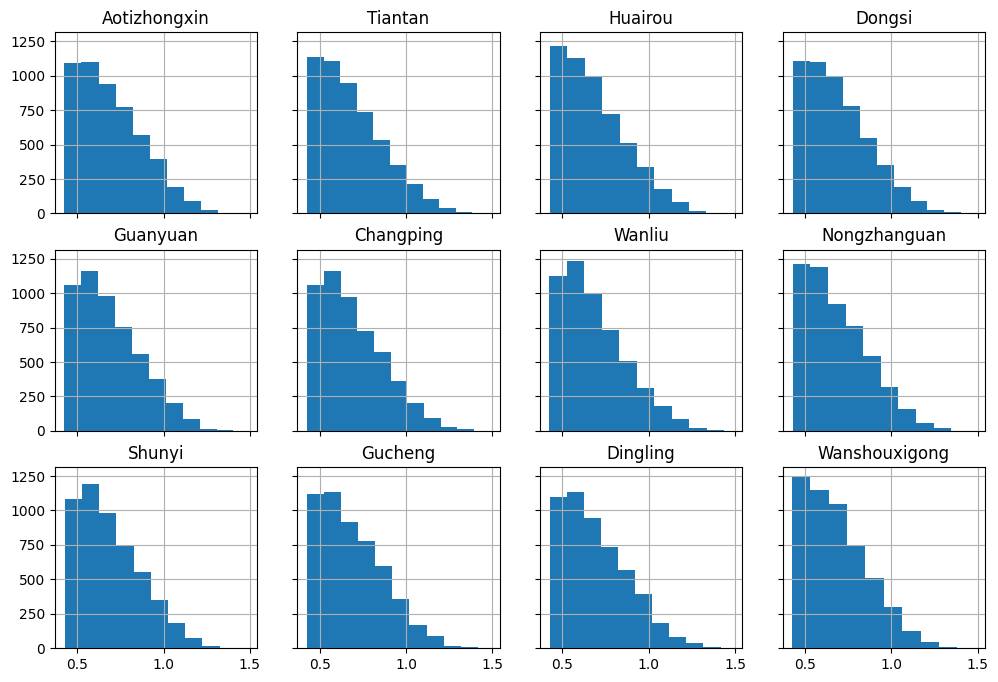

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for i,ess in enumerate(ess_list):
    j=i%3
    k=i%4
    ax[j,k].grid()
    ax[j,k].hist(jnp.log10(ess))
    ax[j,k].set_title(dataset_names[i])
    #ax[j,k].set_ylabel("Expected Sample Size")
    #ax.set_xlabel("$\Sigma$")
plt.show()

# Posterior Predictive

In [221]:
X_test=X_test_datasets
params=samples[-1]
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [222]:
from sklearn import metrics
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:])
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Cerrillos, RMSE : 0.22, MAE :0.30, R2 :0.82
task : CerroNavia, RMSE : 0.10, MAE :0.19, R2 :0.89
task : ElBosque, RMSE : 0.18, MAE :0.27, R2 :0.77
task : Independencia, RMSE : 0.22, MAE :0.32, R2 :0.83
task : LaFlorida, RMSE : 0.22, MAE :0.30, R2 :0.78
task : LasCondes, RMSE : 0.26, MAE :0.35, R2 :0.75
task : ParqueOhiggins, RMSE : 0.25, MAE :0.33, R2 :0.76
task : Pudahuel, RMSE : 0.14, MAE :0.23, R2 :0.85
task : PuenteAlto, RMSE : 0.21, MAE :0.29, R2 :0.75
task : Quilicura, RMSE : 0.22, MAE :0.28, R2 :0.77
task : Talagante, RMSE : 0.30, MAE :0.34, R2 :0.67
-------------------------------------------------------
RMSE : 0.21, MAE :0.29, R2 :0.79


In [223]:
ensemble_pred=list()
X_test=X_test_datasets
for i in range(len(samples)):
    preds=jax.vmap(model.apply, (0, 0))(samples[i], X_test)
    ensemble_pred.append(preds)

In [224]:
ensemble_pred=np.stack(ensemble_pred,axis=-1)

In [225]:
mean_pred=np.mean(ensemble_pred,axis=-1)
std_pred=np.std(ensemble_pred,axis=-1)

In [226]:
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(mean_pred[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(mean_pred[i,:,:],y_test_datasets[i,:,:])
    mae=metrics.mean_absolute_error(mean_pred[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Cerrillos, RMSE : 0.20, MAE :0.30, R2 :0.79
task : CerroNavia, RMSE : 0.10, MAE :0.19, R2 :0.87
task : ElBosque, RMSE : 0.17, MAE :0.26, R2 :0.79
task : Independencia, RMSE : 0.20, MAE :0.30, R2 :0.83
task : LaFlorida, RMSE : 0.21, MAE :0.29, R2 :0.78
task : LasCondes, RMSE : 0.23, MAE :0.33, R2 :0.76
task : ParqueOhiggins, RMSE : 0.27, MAE :0.33, R2 :0.68
task : Pudahuel, RMSE : 0.14, MAE :0.22, R2 :0.84
task : PuenteAlto, RMSE : 0.19, MAE :0.28, R2 :0.72
task : Quilicura, RMSE : 0.20, MAE :0.28, R2 :0.81
task : Talagante, RMSE : 0.27, MAE :0.33, R2 :0.68
-------------------------------------------------------
RMSE : 0.20, MAE :0.28, R2 :0.78


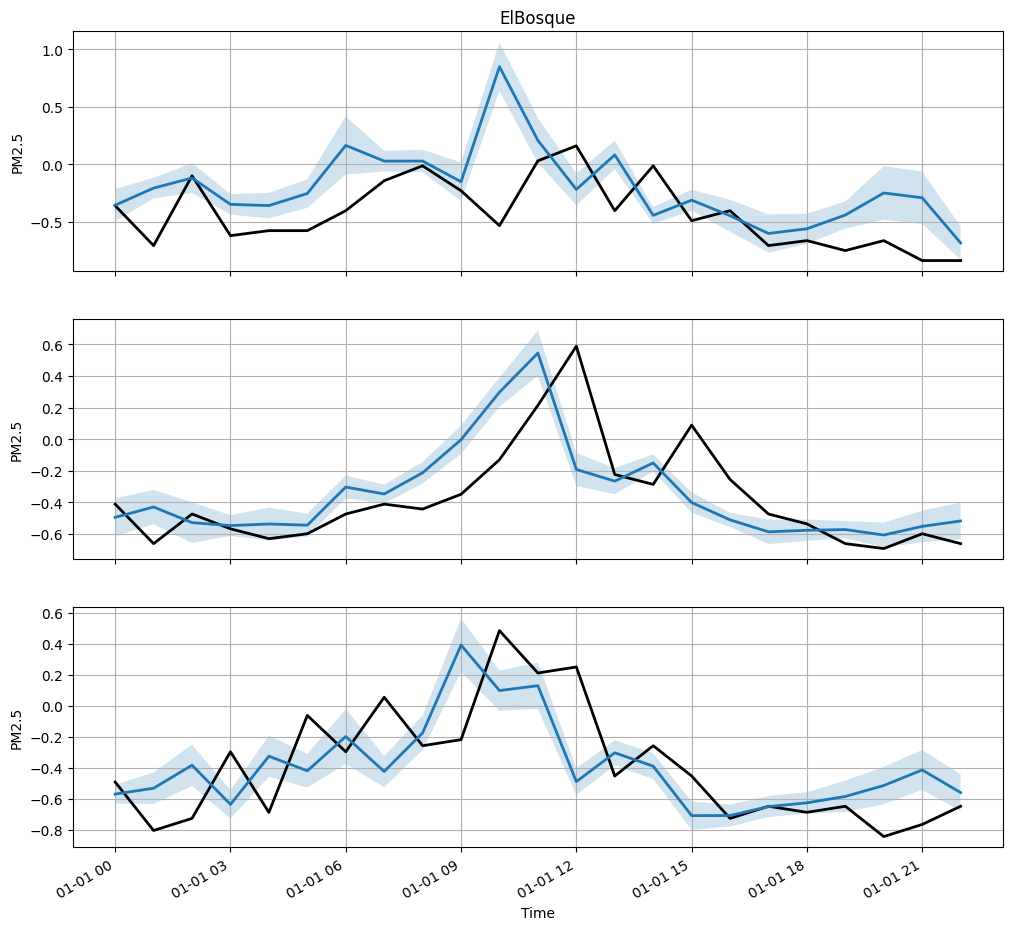

In [228]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=0
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[1,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,2:25,future_pred]-std_pred[1,2:25,future_pred]),np.ravel(mean_pred[1,2:25,future_pred]+std_pred[1,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [174]:
import jaxlib 

jaxlib.__version__

'0.4.30'

In [175]:
import flax 

flax.__version__

'0.8.5'